In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
from file_cache import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

2020-06-18 14:56:49,526 util_log.py[153] INFO Start the program at:amax7, 127.0.1.1, with:Load module


File_cache: Adjust notebook work fold to:/share/felix/pj/brain_seg/


In [2]:
from file_cache import *


In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
#完全厚切
# from file_cache import *

# img_file_list = glob('/share/data2/body/brain/train/image/iNPH_MRI_PROCESSED/**/*.*', recursive=True)

# df = pd.DataFrame({'img_file':img_file_list})
# df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
# df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
# df.sort_values('p_id')

# df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

# df['valid'] = df.p_id%5 >=3

# df.valid.value_counts()

In [5]:
#厚切train/ 薄切valid
# from file_cache import *

# img_file_list = glob('/share/data2/body/brain/*_v3/image/*/**/*.*', recursive=True)

# df = pd.DataFrame({'img_file':img_file_list})
# df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
# df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
# df.sort_values('p_id')

# df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

 
# #
# #df.valid.value_counts()
# df['ds_type'] = df.img_file.apply(lambda val: val.split('/')[5])
# df = df.loc[df.ds_type!='valid_v3']
# df.ds_type.value_counts()
# df['valid'] = df.ds_type=='valid_baocheng_v3'

In [6]:
# #只有薄切
# from file_cache import *

# img_file_list = glob('/share/data2/body/brain/*_v3/image/*/**/*.*', recursive=True)

# df = pd.DataFrame({'img_file':img_file_list})
# df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
# df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
# df.sort_values('p_id')

# df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))
# df['ds_type'] = df.img_file.apply(lambda val: val.split('/')[5])
# df = df.loc[df.ds_type=='valid_baocheng_v3']
# df['valid'] = df.p_id%5 >=4

# df.valid.value_counts()
# #df

In [7]:
#厚切+薄切 train/ 薄切valid
from file_cache import *

img_file_list = glob('/share/data2/body/brain/*_v3/image/*/**/*.*', recursive=True)

df = pd.DataFrame({'img_file':img_file_list})
df['p_id_path'] = df.img_file.apply(lambda val: os.path.dirname(val))
df['p_id'] = df['p_id_path'].rank(method='max').astype(int)
df.sort_values('p_id')

df['label_path'] = df.img_file.apply(lambda val: val.replace('image', 'label'))

 
#
#df.valid.value_counts()
df['ds_type'] = df.img_file.apply(lambda val: val.split('/')[5])
df = df.loc[df.ds_type!='valid_v3']
df.ds_type.value_counts()
df['valid'] = (df.ds_type=='valid_baocheng_v3') & (df.p_id%5 >=4)

df.valid.value_counts()

2020-06-18 14:56:51,661 utils.py[129] INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-06-18 14:56:51,662 utils.py[141] INFO NumExpr defaulting to 8 threads.


False    5502
True      495
Name: valid, dtype: int64

## Datasets

In [8]:
size =224
bs = 8
print('size, bs', size, bs)

size, bs 224 8


In [9]:
codes = range(5)

def get_y_fn(x):
    print(x)
    return x.replace('image', 'label')


src = (SegmentationItemList.from_df(df, path='/', cols='img_file' )
       .split_from_df(col='valid')
       #.label_from_func(get_y_fn, classes=codes)
       .label_from_df(cols='label_path', classes=codes)
      )
       #.label_from_func(cols='label_path', classes=codes))
    
print(len(src.train), len(src.valid))

#
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

5502 495


In [10]:
# tmp = df.groupby(['p_id', 'valid'], as_index=False).label_path.count()
# tmp.pivot_table(index='p_id', columns='valid', values='label_path').sort_values(0)

In [11]:
for a, b in data.dl(DatasetType.Train):
    break
    
a.shape

torch.Size([8, 3, 224, 224])

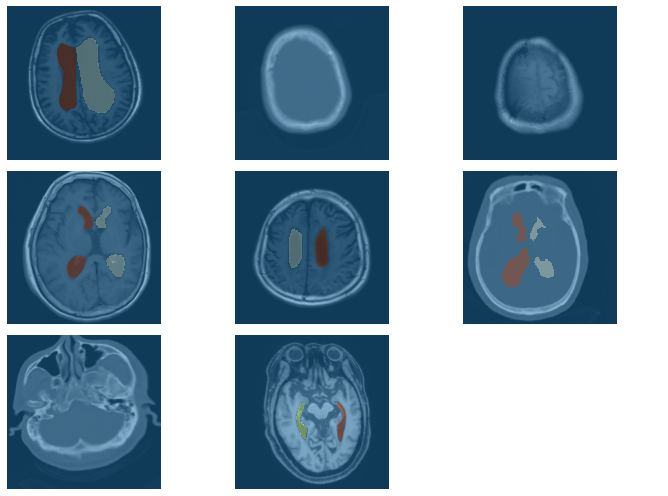

In [12]:
data.show_batch(4, figsize=(10, 7))

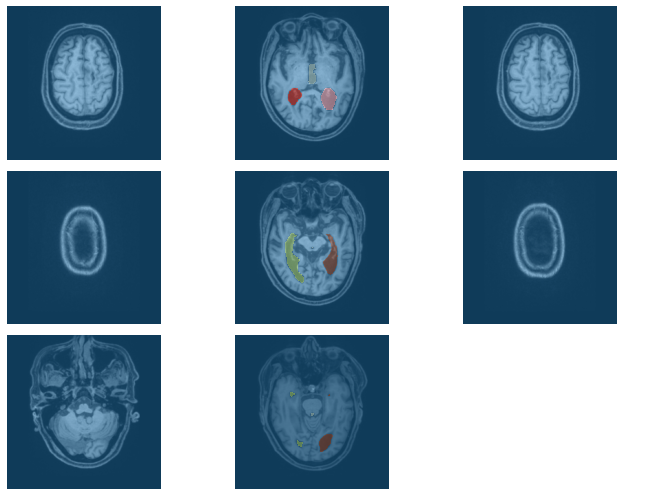

In [13]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [14]:
name2id = {v:k for k,v in enumerate(codes)}
#void_code = name2id['Void']

# def acc_camvid(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [15]:
wd = 1e-2


In [2]:
from fastai.vision import models
models.resnet34?

In [17]:
#多类别的Dice Metrics

from brain.metrics import * 

from functools import partial
def dice_fn(cls_id):
    fn = partial(dice_multiply, cls_id=cls_id) 
    fn.__name__ = f'dice_{cls_id}'
    return fn
 

metrics = [ dice_fn(i) for i in range(5) ] #, accuracy,

import ipdb
# ipdb.set_trace()
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

# for sn, child in enumerate(learn.model.children()):
#     print(sn, '===', child)

In [18]:
os.path.abspath('./output/model')

'/share/felix/pj/brain_seg/output/model'

In [19]:

learn.model_dir=os.path.abspath('./output/model')
os.makedirs(learn.model_dir, exist_ok=True)
learn.lr_find()

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


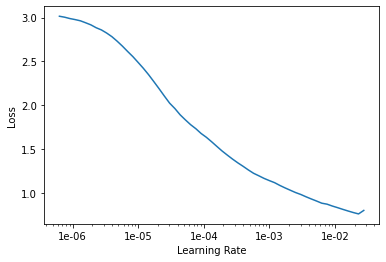

In [20]:
learn.recorder.plot()

In [21]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.051816,0.026545,0.997548,0.664113,0.722498,0.876854,0.774653,02:13
1,0.035873,0.018611,0.998162,0.733568,0.759167,0.796532,0.804833,02:27
2,0.028015,0.015410,0.998849,0.721151,0.790298,0.940375,0.873568,02:42
3,0.023674,0.014440,0.999228,0.739083,0.770020,0.959220,0.891738,02:14
4,0.019983,0.013139,0.999318,0.813953,0.790780,0.957991,0.905521,02:15


In [22]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.020387,0.013176,0.999276,0.779914,0.804893,0.966784,0.903578,02:13
1,0.020721,0.012896,0.999321,0.814591,0.771757,0.967742,0.909593,02:22
2,0.021846,0.014628,0.999298,0.705911,0.750606,0.967393,0.917199,02:49
3,0.021479,0.013993,0.999341,0.786435,0.752896,0.970970,0.914632,02:13
4,0.019660,0.013572,0.999372,0.700859,0.814808,0.967680,0.918630,02:12


In [23]:
lr = 1e-3
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.019527,0.013862,0.999329,0.811204,0.640934,0.965434,0.924614,02:15
1,0.025845,0.016768,0.998403,0.805740,0.683479,0.926705,0.854118,02:15
2,0.024879,0.013922,0.999355,0.694054,0.815655,0.967411,0.886951,03:02
3,0.026029,0.013840,0.999354,0.702692,0.821576,0.966507,0.923311,02:12
4,0.020749,0.013220,0.999416,0.686510,0.819517,0.972785,0.923728,02:18


In [24]:
lr = 1e-4
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.018874,0.013237,0.999402,0.707405,0.811586,0.972181,0.923570,02:13
1,0.018081,0.013149,0.999411,0.700406,0.820613,0.972417,0.927124,02:13
2,0.018257,0.013160,0.999407,0.754494,0.779299,0.972147,0.928171,03:02
3,0.017640,0.013063,0.999415,0.725437,0.810177,0.973024,0.936823,02:13
4,0.019197,0.013023,0.999411,0.790134,0.762454,0.973258,0.940435,02:11
5,0.017894,0.013045,0.999413,0.760174,0.793672,0.971279,0.947446,02:10
6,0.017639,0.013967,0.999420,0.729171,0.743462,0.973251,0.950794,02:11
7,0.018119,0.014448,0.999402,0.736478,0.706371,0.975085,0.946147,02:45
8,0.017394,0.013189,0.999435,0.661005,0.832856,0.974279,0.955822,02:25
9,0.016738,0.011058,0.999430,0.815345,0.854093,0.973987,0.955510,02:13


In [25]:
lr = 1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,dice_0,dice_1,dice_2,dice_3,dice_4,time
0,0.016905,0.011195,0.999428,0.800399,0.849680,0.973874,0.949683,02:13
1,0.016824,0.012360,0.999425,0.783437,0.817969,0.972897,0.955262,02:12
2,0.017029,0.012373,0.999430,0.743181,0.836850,0.973596,0.956195,02:15
3,0.016272,0.008679,0.999421,0.853407,0.875478,0.973575,0.951243,02:52
4,0.017965,0.009805,0.999431,0.804720,0.867129,0.974263,0.947829,02:12


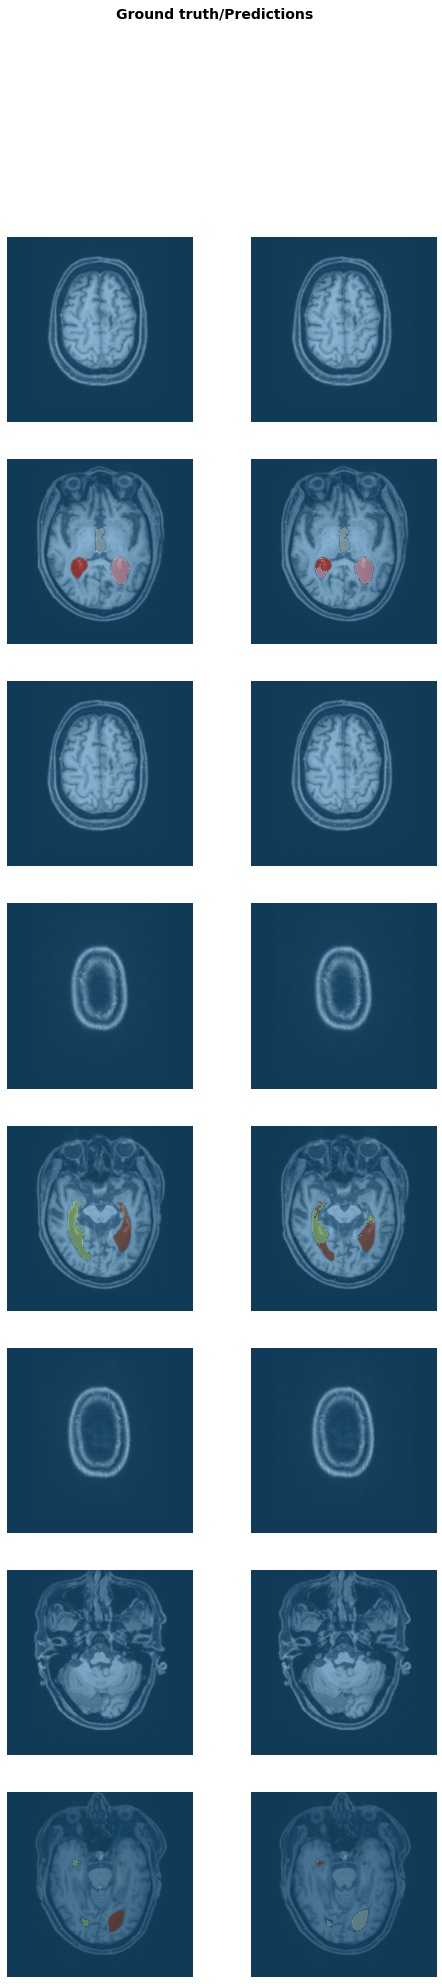

In [26]:
learn.show_results(DatasetType.Valid, rows=40)
